## Практическая работа №2
Необходимо с использованием результатов, полученных при выполнении Практической работы №1, спроектировать и реализовать прототип семантического анализатора естественного языка (Latent semantic analysis, LSA). Используйте векторы TF-IDF, векторы тем, стиринг и т.п.

In [313]:
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [314]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Класс отчистки текста
Класс TextCleaner выполняет предобработку текстов песен, очищая их от лишних символов, пунктуации и стоп слов, а также приводя все слова к нижнему регистру и их базовой форме с помощью лемматизации. За счет этого тексты получаются унифицироваными и готовыми к дальнейшему векторному представлению и семантическому анализу.

In [315]:
class TextCleaner:
    _whitespace_re = re.compile(r"\s+")
    _non_alnum_re = re.compile(r"[^a-zA-Z0-9]")

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text: str) -> str:
        text = self._whitespace_re.sub(" ", text)
        text = self._non_alnum_re.sub(" ", text)
        text = text.lower()
        words = word_tokenize(text)
        words = [self.lemmatizer.lemmatize(w) for w in words if w not in self.stop_words]
        return " ".join(words)

### Функция семантического анализа
Выполняет TF-IDF, LSA и расчёт косинусного сходства. Возвращает DataFrame с матрицей сходства.

In [316]:
def semantic_analysis(texts, n_components=2, max_features=1000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(texts)

    lsa = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_matrix = lsa.fit_transform(tfidf_matrix)

    similarity_matrix = cosine_similarity(lsa_matrix)
    df_sim = pd.DataFrame(similarity_matrix)
    df_sim.index = [f"Sent {i+1}" for i in range(len(texts))]
    df_sim.columns = [f"Sent {i+1}" for i in range(len(texts))]
    return df_sim

### Функция визуализации
Строит тепловую карту семантической близости текстов.

In [317]:
def visualize_similarity(df_sim, title="Семантическая близость предложений"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_sim, cmap="YlGnBu", annot=True, fmt=".2f")
    plt.title(title)
    plt.show()

### Загрузка данных

In [318]:
path = "data/text.txt"

try:
    with open(path, "r", encoding="utf-8") as f:
        raw_text = f.read()
except FileNotFoundError:
    raise FileNotFoundError("Файл text.txt не найден.")

In [319]:
print(raw_text)

I love cooking pasta with different sauces.
Yesterday we had dinner at an Italian restaurant.
Fresh vegetables are good for your health.
My favorite dessert is chocolate cake.
For breakfast, I usually eat oatmeal with fruits.
I go jogging in the park every morning.
The football team won yesterday's match.
Yoga helps me relax and relieve stress.
He trains at the gym five times a week.
Swimming is a great way to stay in shape.
I bought a new smartphone with a good camera.
Artificial intelligence is changing many professions.
Computer games help improve reaction time.
I use cloud storage for my files.
In the future, robots will perform routine tasks.


In [320]:
sentences = sent_tokenize(raw_text)
sentences = [s.strip() for s in sentences if len(s.strip()) > 0][:20]  # берём первые 20 предложений

print(f"Всего предложений для анализа: {len(sentences)}")

Всего предложений для анализа: 15


### Отчистка текста

In [321]:
cleaner = TextCleaner()
cleaned_sentences = [cleaner.clean_text(s) for s in sentences]

### Семантический анализ текстов песен

In [322]:
df_sim = semantic_analysis(cleaned_sentences)

In [323]:
print("Семантическая близость:")
display(df_sim.round(2).head(15))

Семантическая близость:


,Sent 1,Sent 2,Sent 3,Sent 4,Sent 5,Sent 6,Sent 7,Sent 8,Sent 9,Sent 10,Sent 11,Sent 12,Sent 13,Sent 14,Sent 15
Sent 1,1.00,0.63,-0.99,0.95,-0.97,0.77,0.57,-0.81,-0.78,0.30,-0.98,0.32,-0.79,0.71,-1.00
Sent 2,0.63,1.00,-0.75,0.35,-0.43,-0.01,1.00,-0.05,-0.01,0.93,-0.77,0.94,-0.01,-0.09,-0.66
Sent 3,-0.99,-0.75,1.00,-0.89,0.92,-0.66,-0.69,0.70,0.67,-0.45,1.00,-0.47,0.68,-0.60,0.99
Sent 4,0.95,0.35,-0.89,1.00,-1.00,0.93,0.28,-0.95,-0.94,-0.01,-0.87,0.01,-0.94,0.90,-0.93
Sent 5,-0.97,-0.43,0.92,-1.00,1.00,-0.90,-0.36,0.92,0.91,-0.07,0.91,-0.09,0.91,-0.86,0.96
Sent 6,0.77,-0.01,-0.66,0.93,-0.90,1.00,-0.09,-1.00,-1.00,-0.37,-0.64,-0.36,-1.00,1.00,-0.74
Sent 7,0.57,1.00,-0.69,0.28,-0.36,-0.09,1.00,0.03,0.07,0.96,-0.71,0.96,0.07,-0.17,-0.60
Sent 8,-0.81,-0.05,0.70,-0.95,0.92,-1.00,0.03,1.00,1.00,0.32,0.68,0.30,1.00,-0.99,0.78
Sent 9,-0.78,-0.01,0.67,-0.94,0.91,-1.00,0.07,1.00,1.00,0.36,0.65,0.34,1.00,-0.99,0.75
Sent 10,0.30,0.93,-0.45,-0.01,-0.07,-0.37,0.96,0.32,0.36,1.00,-0.48,1.00,0.35,-0.45,-0.34


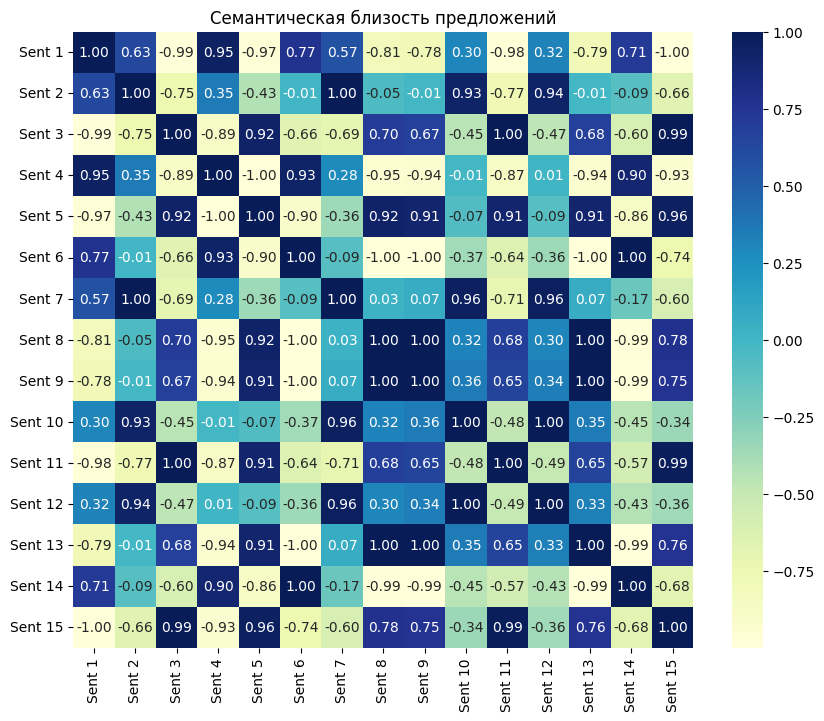

In [324]:
visualize_similarity(df_sim)